# Understand the problems
## Context
Having csv file containing information about car listings. Defined tasks:
1. Build a model
- Work on brands make up 90% of the total cars -> Maybe filtering is a good option. 
- Predict the price of used cars -> Regression task
2. Define a success metrics 
- Maybe metrics related to regression tasks, including:
    - functional metrics -> MSE, R-squared
    - non-functional metrics -> inference time per request, 
3. Build an API
- Objective is to develop a RESTful API for the model mentioned above -> Since this is a demo, maybe i will stick with FastAPI for a fast demo.
4. Data Analysis Questions
- How does mileage relate to car price? Is there a clear negative correlation? -> I think this question is more data-centric instead of model-centric, therefore using modeling techniques like SHAP value to interprete maybe is not suitable. Thus, sticking with statistic methods maybe more general. 
- Does the fuel type (petrol, diesel, etc.) have a noticeable impact on price? -> I can reframe this question as is fuel type is statistical significant with the price -> Maybe using statistics test -> Using some libraries. 
- How to compare two cars in the same segment? -> Still thinking (what is segment mean?)

## Scoring objective:
- How well does your model perform -> This maybe strongly related to the chosen metrics. 
- How effective is the selected metric in evaluating model performance -> Are these metrics align with what people are doing in real-life problem?
- How could your model be improved? -> Tbh, both modeling and data preparation are needed in order to improve the model's prediction. 

# Import libraries

In [89]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import sys

In [3]:
# Load data
data_path = 'data/raw'
ref = pd.read_csv(f'{data_path}/car.csv') # for reference if needed
data = pd.read_csv(f'{data_path}/car.csv')

In [4]:
unique_df = ref[~ref.duplicated()]
unique_df

,id,list_id,list_time,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,148468232,108616925,1693378633111,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,149864917,109805135,1694308247000,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
2,149580046,109560282,1693462201000,2016,Kia,Rio,Hàn Quốc,NaN,NaN,AT,petrol,NaN,78545,295000000.0,used
3,148601679,108727914,1693493126176,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
4,149530234,109517456,1693313503000,2001,Fiat,Siena,NaN,NaN,NaN,MT,petrol,white,200000,73000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317611,150748445,110565749,1696580444000,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317613,150811050,110619804,1696753826000,2015,Kia,K3,NaN,Sedan,5.0,AT,petrol,white,1234,370000000.0,used
317617,150840647,110645035,1696835873000,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used
317618,148874300,108958993,1696836032000,2007,Hyundai,Veracruz,Hàn Quốc,SUV / Cross over,7.0,AT,oil,NaN,110000,535000000.0,used


In [5]:
# Take a random sample
sample_record = data.sample(n=1)

# Convert the sample record to a dictionary
sample_dict = sample_record.to_dict(orient='records')[0]

print(sample_dict)

{'id': 149309651, 'list_id': 109328672, 'list_time': 1698037215000, 'manufacture_date': 2019, 'brand': 'Hyundai', 'model': 'Tucson', 'origin': 'Việt Nam', 'type': 'SUV / Cross over', 'seats': 5.0, 'gearbox': 'AT', 'fuel': 'oil', 'color': 'red', 'mileage_v2': 51000, 'price': 699000000.0, 'condition': 'used'}


# EDA and Preprocessing

## Overview

In [6]:
# Check for the shape of the data
data.shape

(317636, 15)

Currently, the data has 317636 rows  with 15 columns

In [7]:
# Check for the first 5 rows of the data
data.head()

,id,list_id,list_time,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,148468232,108616925,1693378633111,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,149864917,109805135,1694308247000,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
2,149580046,109560282,1693462201000,2016,Kia,Rio,Hàn Quốc,NaN,NaN,AT,petrol,NaN,78545,295000000.0,used
3,148601679,108727914,1693493126176,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
4,149530234,109517456,1693313503000,2001,Fiat,Siena,NaN,NaN,NaN,MT,petrol,white,200000,73000000.0,used


This is what the first 5 records look like. It seems that id, list_id, list_time are quite vague -> need to ask stakeholders about the data dictionary.

## Convert data types

In [8]:
# Check for the data types of the columns
data.dtypes

id                    int64
list_id               int64
list_time             int64
manufacture_date      int64
brand                object
model                object
origin               object
type                 object
seats               float64
gearbox              object
fuel                 object
color                object
mileage_v2            int64
price               float64
condition            object
dtype: object

In [9]:
# Convert data types of the columns
data['brand'] = data['brand'].astype('category')
data['model'] = data['model'].astype('category')
data['origin'] = data['origin'].astype('category')    
data['gearbox'] = data['gearbox'].astype('category')
data['fuel'] = data['fuel'].astype('category')
data['type'] = data['type'].astype('category')
data['color'] = data['color'].astype('category')
data['condition'] = data['condition'].astype('category')
data.dtypes

id                     int64
list_id                int64
list_time              int64
manufacture_date       int64
brand               category
model               category
origin              category
type                category
seats                float64
gearbox             category
fuel                category
color               category
mileage_v2             int64
price                float64
condition           category
dtype: object

We have to convert the data back to the correct data type. Although in some scenario, object and category can be used interchangeably, I still prefer category over object, especially for these variable.

## Handling duplicate

In [10]:
duplicates = data[data.duplicated(keep=False) | data.duplicated(keep='first')]
duplicates.sort_values(by=list(duplicates.columns))

,id,list_id,list_time,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
206668,45885586,29890521,1695457603346,2023,Ford,Ranger,Việt Nam,Pick-up (bán tải),5.0,MT,oil,others,0,195000000.0,used
210744,45885586,29890521,1695457603346,2023,Ford,Ranger,Việt Nam,Pick-up (bán tải),5.0,MT,oil,others,0,195000000.0,used
215483,45885586,29890521,1695457603346,2023,Ford,Ranger,Việt Nam,Pick-up (bán tải),5.0,MT,oil,others,0,195000000.0,used
220510,45885586,29890521,1695457603346,2023,Ford,Ranger,Việt Nam,Pick-up (bán tải),5.0,MT,oil,others,0,195000000.0,used
225051,45885586,29890521,1695457603346,2023,Ford,Ranger,Việt Nam,Pick-up (bán tải),5.0,MT,oil,others,0,195000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199907,151369542,111096726,1698207185000,2022,Mitsubishi,Outlander,Việt Nam,SUV / Cross over,7.0,AT,petrol,white,56000,699000000.0,used
191306,151369657,111096801,1698207292000,2023,Kia,Sportage,Hàn Quốc,SUV / Cross over,6.0,AT,petrol,blue,0,799000000.0,new
191307,151369657,111096801,1698207292000,2023,Kia,Sportage,Hàn Quốc,SUV / Cross over,6.0,AT,petrol,blue,0,799000000.0,new
187682,151369827,111096948,1698207471000,2022,Honda,City,NaN,NaN,5.0,AT,petrol,NaN,14000,526000000.0,used


We can say that the data is duplicate a lot. Therefore I will decide to drop those duplicated columns. 

In [11]:
data = data.drop_duplicates()
print(f'The data now has: {data.shape[0]} rows and {data.shape[1]} columns')

The data now has: 81458 rows and 15 columns


After deleting duplicate data, we reduce the data from 317636 records to 81545 records. However, further investigation is also needed to ensure that the data is correct for modeling and analysis

In [12]:
# Check if the combination of these 3 create unique identifiers
data['id_list_id_list_time'] = data['id'].astype(str) + '_' + data['list_id'].astype(str) + '_' + data['list_time'].astype(str)
data['id_list_id_list_time'].nunique()

78793

Eventhough after remove duplicate, there still something suspicious that need to be addressed. We can see that based on variable that has potential to be the identifier, there are only 78793 unique record of them while there are 81458 records in general. Therefore it must exists some records that have the same identifier but different value so that the drop_duplicates function do not consider as duplicate during the dropping process. 

In [13]:
# Count the number of duplicated id_list_id_list_time entries
num_duplicates = data.duplicated(subset='id_list_id_list_time', keep=False).sum()
print(f'The number of duplicated id_list_id_list_time entries is: {num_duplicates}')
# Print records that have the same id_list_id_list_time
duplicate_records = data[data.duplicated(subset='id_list_id_list_time', keep=False)]
duplicate_records.sort_values(by='id_list_id_list_time')

The number of duplicated id_list_id_list_time entries is: 5083


,id,list_id,list_time,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,id_list_id_list_time
313032,117352121,83260326,1696471572424,2023,Toyota,Veloz,Việt Nam,Kiểu dáng khác,7.0,AT,petrol,NaN,0,636000000.0,new,117352121_83260326_1696471572424
312857,117352121,83260326,1696471572424,2023,Toyota,Veloz,Nước khác,Minivan (MPV),7.0,AT,petrol,NaN,0,636000000.0,new,117352121_83260326_1696471572424
312658,117352121,83260326,1696471572424,2023,Toyota,Veloz,Nước khác,Minivan (MPV),7.0,AT,petrol,NaN,0,633000000.0,used,117352121_83260326_1696471572424
45602,118054232,83797920,1695695984878,2023,Kia,Seltos,Việt Nam,SUV / Cross over,5.0,AT,petrol,gold,0,594000000.0,new,118054232_83797920_1695695984878
29310,118054232,83797920,1695695984878,2023,Kia,Seltos,Việt Nam,SUV / Cross over,5.0,AT,petrol,gold,0,599000000.0,new,118054232_83797920_1695695984878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254581,151161873,110920167,1697638498000,2017,Mazda,CX 5,Việt Nam,SUV / Cross over,5.0,AT,petrol,NaN,80000,540000000.0,used,151161873_110920167_1697638498000
310772,151162690,110920887,1697640669000,2020,Toyota,Corolla Altis,NaN,Sedan,5.0,AT,petrol,NaN,40000,639000000.0,used,151162690_110920887_1697640669000
310614,151162690,110920887,1697640669000,2019,Toyota,Corolla Altis,NaN,Sedan,5.0,AT,petrol,NaN,29000,555000000.0,used,151162690_110920887_1697640669000
294870,151165495,110923011,1697669043000,2022,Kia,Sonet,Hàn Quốc,Sedan,5.0,AT,petrol,red,15000,560000000.0,used,151165495_110923011_1697669043000


There may be some potential errors , for instance, there are 2 records with the same values for features but with different prices (try with id_list_id_list_time=151165495_110923011_1697669043000). I talk about potential errors, but it is also the cased where people have different perspective on how to define the sale price of the car. Addtionally, it seems like the price is not fluctuated heavily. Therefore, one potential solution is to take the average of them. However, I will let it be for now and move on to dealing with missing values.

## Handling missing values

In [15]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
id,0,0.000000,int64
list_id,0,0.000000,int64
list_time,0,0.000000,int64
manufacture_date,0,0.000000,int64
brand,22,0.027008,category
model,22,0.027008,category
origin,23021,28.261190,category
type,11148,13.685580,category
seats,8775,10.772423,float64
gearbox,326,0.400206,category


If we put ourselves under the view of the buyer, we will definately not buy the car if we do not know what brand it was or what model it was. Therefore these fields may be very important to determine the sale price of the car. With that being said, I will drop records where brand, model and price is empty. 

In [17]:
# Records with missing values in the 'price','brand','model' column
# Select and print records with missing values in 'brand', 'model', and 'target'
missing_records = data[data[['brand', 'model', 'price']].isnull().any(axis=1)]
print("Records with missing values in 'brand', 'model', and 'target':")
missing_records

Records with missing values in 'brand', 'model', and 'target':


,id,list_id,list_time,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,id_list_id_list_time
1059,151369180,111096516,1698206937000,2023,Hyundai,Grand i10,Việt Nam,NaN,5.0,AT,petrol,NaN,0,NaN,new,151369180_111096516_1698206937000
1727,143905366,104804174,1695347537429,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,90000,190000000.0,used,143905366_104804174_1695347537429
4455,143905366,104804174,1696405507802,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,90000,190000000.0,used,143905366_104804174_1696405507802
5517,150658937,110488422,1696383435000,2005,Ford,Transit,NaN,Van,16.0,MT,oil,NaN,280000,NaN,used,150658937_110488422_1696383435000
5525,143905366,104804174,1696578308081,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,90000,190000000.0,used,143905366_104804174_1696578308081
5993,150658937,110488422,1696778802810,2005,Ford,Transit,NaN,Van,16.0,MT,oil,NaN,280000,NaN,used,150658937_110488422_1696778802810
6108,143905366,104804174,1696751106157,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,90000,190000000.0,used,143905366_104804174_1696751106157
6744,143905366,104804174,1696923906073,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,90000,190000000.0,used,143905366_104804174_1696923906073
12848,150331092,110207208,1695484060000,2023,Ford,Everest,Thái Lan,SUV / Cross over,7.0,AT,oil,NaN,0,NaN,new,150331092_110207208_1695484060000
20958,149573904,109555495,1693452835000,2022,Suzuki,Ertiga,Nước khác,NaN,7.0,AT,hybrid,NaN,0,NaN,new,149573904_109555495_1693452835000


Maybe I will keep records with missing price for later inferencing (if these records are missing the price only). The remains can be dropped.

In [20]:
# Keep records with missing 'price' only
missing_price_only = data[data['price'].isnull() & data.drop(columns=['price']).notnull().all(axis=1)]
print("Records with missing 'price' only:")
missing_price_only

Records with missing 'price' only:


,id,list_id,list_time,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,id_list_id_list_time
22164,149078325,109132753,1693020012100,2023,Hyundai,Accent,Việt Nam,Sedan,5.0,AT,petrol,white,0,NaN,new,149078325_109132753_1693020012100
23120,146913084,107300282,1694577922666,2023,Hyundai,Accent,Hàn Quốc,Sedan,5.0,AT,petrol,white,0,NaN,new,146913084_107300282_1694577922666
32908,146913084,107300282,1695866502353,2023,Hyundai,Accent,Hàn Quốc,Sedan,5.0,AT,petrol,white,0,NaN,new,146913084_107300282_1695866502353
73476,146913084,107300282,1696131288381,2023,Hyundai,Accent,Hàn Quốc,Sedan,5.0,AT,petrol,white,0,NaN,new,146913084_107300282_1696131288381
133624,146913084,107300282,1696665170625,2023,Hyundai,Accent,Hàn Quốc,Sedan,5.0,AT,petrol,white,0,NaN,new,146913084_107300282_1696665170625
159136,142193083,103363081,1697428800618,2011,Toyota,Fortuner,Việt Nam,SUV / Cross over,7.0,AT,petrol,silver,110000,NaN,used,142193083_103363081_1697428800618
165378,151062809,110836909,1697508696688,2022,Hyundai,Stargazer,Hàn Quốc,Minivan (MPV),7.0,AT,petrol,white,0,NaN,new,151062809_110836909_1697508696688
169034,150402026,110267643,1697598569197,2023,Hyundai,Custin,Việt Nam,Minivan (MPV),7.0,AT,petrol,white,0,NaN,new,150402026_110267643_1697598569197
177070,151141221,110902640,1697602741000,2023,Hyundai,Accent,Việt Nam,Sedan,5.0,AT,petrol,white,0,NaN,new,151141221_110902640_1697602741000
181000,151140755,110902757,1697644330717,2022,Hyundai,Stargazer,Nước khác,Minivan (MPV),7.0,AT,petrol,white,0,NaN,new,151140755_110902757_1697644330717


In [27]:
missing_price_only.to_csv((f'{data_path}/inference.csv'), index=False)
data = data[~data.index.isin(missing_records.index)]


In [28]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
id,0,0.000000,int64
list_id,0,0.000000,int64
list_time,0,0.000000,int64
manufacture_date,0,0.000000,int64
brand,0,0.000000,category
model,0,0.000000,category
origin,22994,28.246075,category
type,11120,13.659927,category
seats,8750,10.748593,float64
gearbox,326,0.400462,category


Ok, now we need to further investigate to see what we can do to the remaining missing values. 

In [29]:
# Overall statistics of the data
data.describe(include='all')

,id,list_id,list_time,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,id_list_id_list_time
count,8.140600e+04,8.140600e+04,8.140600e+04,81406.000000,81406,81406,58412,70286,72656.000000,81080,81392,55342,81406.000000,8.140600e+04,81406,81406
unique,NaN,NaN,NaN,NaN,67,521,10,9,NaN,4,4,12,NaN,NaN,2,78744
top,NaN,NaN,NaN,NaN,Toyota,Innova,Việt Nam,Sedan,NaN,AT,petrol,white,NaN,NaN,used,150244549_110131994_1695269891000
freq,NaN,NaN,NaN,NaN,17149,3856,30037,23889,NaN,60823,67195,17761,NaN,NaN,72035,7
mean,1.488794e+08,1.089859e+08,1.696255e+12,2016.424232,NaN,NaN,NaN,NaN,5.689799,NaN,NaN,NaN,64822.631194,5.972847e+08,NaN,NaN
std,3.680123e+06,3.037297e+06,1.221732e+09,6.158575,NaN,NaN,NaN,NaN,1.752714,NaN,NaN,NaN,92294.800099,6.841684e+08,NaN,NaN
min,4.588559e+07,2.989052e+07,1.691400e+12,1980.000000,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,0.000000,1.310720e+06,NaN,NaN
25%,1.488181e+08,1.089123e+08,1.695557e+12,2014.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,12345.000000,2.990000e+08,NaN,NaN
50%,1.499746e+08,1.099001e+08,1.696381e+12,2018.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,50000.000000,4.690000e+08,NaN,NaN
75%,1.505789e+08,1.104202e+08,1.697185e+12,2021.000000,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,86000.000000,6.800000e+08,NaN,NaN


We can notice that the id, list_id and list_time does not bring anything to help us to develop the prediction model, therefore we can drop them easily.Additionally, seats also have a values where it is equal to -1, which obviously wrong :). Detect and drop those as well. 

In [30]:
# Drop the columns
data = data.drop(columns=['id', 'list_id', 'list_time'])

# Drop rows where seats is less than or equal to 0
data = data[data['seats'] > 0]

data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,id_list_id_list_time
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used,148468232_108616925_1693378633111
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used,149864917_109805135_1694308247000
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used,148601679_108727914_1693493126176
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used,148583720_108712558_1694932494416
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used,150061598_109974620_1694955795249
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used,150748445_110565749_1696580444000
317613,2015,Kia,K3,NaN,Sedan,5.0,AT,petrol,white,1234,370000000.0,used,150811050_110619804_1696753826000
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used,150840647_110645035_1696835873000
317618,2007,Hyundai,Veracruz,Hàn Quốc,SUV / Cross over,7.0,AT,oil,NaN,110000,535000000.0,used,148874300_108958993_1696836032000


In [31]:
data.describe(include='all')

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,id_list_id_list_time
count,72477.000000,72477,72477,56534,69178,72477.000000,72151,72477,53974,72477.000000,7.247700e+04,72477,72477
unique,NaN,66,481,10,9,NaN,3,4,12,NaN,NaN,2,70063
top,NaN,Toyota,Innova,Việt Nam,Sedan,NaN,AT,petrol,white,NaN,NaN,used,150244549_110131994_1695269891000
freq,NaN,15566,3580,29284,23618,NaN,54267,59578,17276,NaN,NaN,63208,7
mean,2016.592243,NaN,NaN,NaN,NaN,5.706321,NaN,NaN,NaN,63926.533273,5.930282e+08,NaN,NaN
std,5.984601,NaN,NaN,NaN,NaN,1.723018,NaN,NaN,NaN,89555.323077,6.242655e+08,NaN,NaN
min,1980.000000,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,0.000000,1.310720e+06,NaN,NaN
25%,2014.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,12345.000000,3.050000e+08,NaN,NaN
50%,2018.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,50000.000000,4.730000e+08,NaN,NaN
75%,2021.000000,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,86000.000000,6.850000e+08,NaN,NaN


In [32]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.000000,int64
brand,0,0.000000,category
model,0,0.000000,category
origin,15943,21.997323,category
type,3299,4.551789,category
seats,0,0.000000,float64
gearbox,326,0.449798,category
fuel,0,0.000000,category
color,18503,25.529478,category
mileage_v2,0,0.000000,int64


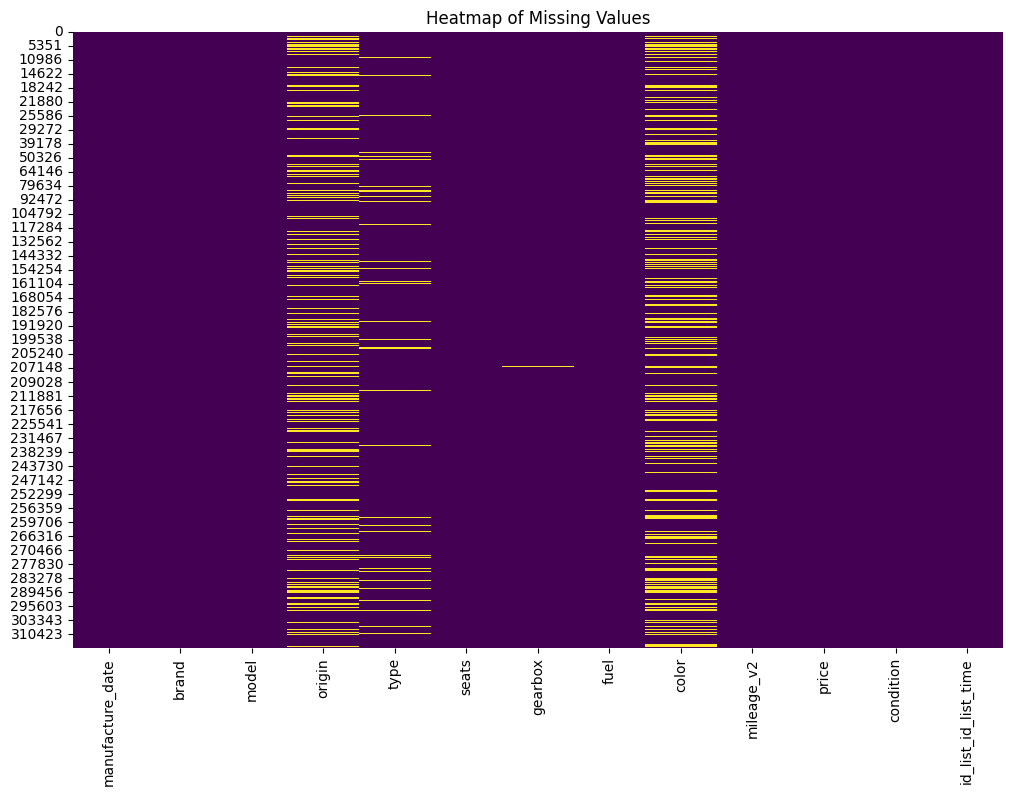

In [52]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

We can see that there is some missing regions, my best guests is that something must went wrong in the data gathering process, which lead to this bizard situations. I suspect that some brand and models are so unique such that it only have one type/origin or so on. I will need to investigate on that as well. 

In [62]:
# Group by 'brand' and 'model' and count occurrences
brand_model_counts = data.groupby(['brand', 'model']).size().reset_index(name='count')
# Sort the values in descending order
brand_model_counts = brand_model_counts.sort_values(by='count', ascending=False)

/tmp/ipykernel_38825/3156361840.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  brand_model_counts = data.groupby(['brand', 'model']).size().reset_index(name='count')


In [67]:
# Identify unique or rare combinations
unique_combinations = brand_model_counts[(brand_model_counts['count'] >= 1) & (brand_model_counts['count'] <= 5)]
# Filter the original DataFrame to get records with unique combinations
unique_records = data[data.set_index(['brand', 'model']).index.isin(unique_combinations.set_index(['brand', 'model']).index)]
print("Records with unique or rare brand and model combinations:")
unique_records

Records with unique or rare brand and model combinations:


,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,id_list_id_list_time
76,2023,Hyundai,County,Việt Nam,Minivan (MPV),7.0,AT,petrol,black,0,848000000.0,new,150061379_109974410_1694786335000
1341,2003,Hyundai,Libero,Hàn Quốc,Pick-up (bán tải),4.0,MT,oil,white,262000,125000000.0,used,150222381_110112943_1695202828000
1398,2010,Kia,Magentis,Việt Nam,Hatchback,4.0,MT,petrol,silver,130000,100000000.0,used,148539293_108675098_1694748153966
2428,2010,Kia,Magentis,Việt Nam,Hatchback,4.0,MT,petrol,silver,130000,100000000.0,used,148539293_108675098_1695630142561
3213,2009,Isuzu,NMR,Nhật Bản,Kiểu dáng khác,2.0,AT,petrol,white,310000,250000000.0,used,150556553_110400603_1696081603000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
316823,2013,SYM,T880,Hàn Quốc,Van,5.0,MT,petrol,gold,8888,68000000.0,used,148880480_108964259_1695702934810
316926,2013,SYM,T880,Hàn Quốc,Van,5.0,MT,petrol,gold,8888,68000000.0,used,148880480_108964259_1696213866621
317043,2013,SYM,T880,Hàn Quốc,Van,5.0,MT,petrol,gold,8888,68000000.0,used,148880480_108964259_1696730608324
317166,1997,Lada,Dòng khác,Nhật Bản,Sedan,5.0,MT,hybrid,blue,1235,10000000.0,used,151019193_110799303_1697272748000


In [68]:
# Check if there is any missing values in these records
unique_records_missing = unique_records.isnull().sum()
unique_records_missing 

manufacture_date         0
brand                    0
model                    0
origin                  25
type                    42
seats                    0
gearbox                  0
fuel                     0
color                   57
mileage_v2               0
price                    0
condition                0
id_list_id_list_time     0
dtype: int64

Now the remaining problems is how to deal with origin, type and color. When we reach this step, I think that visualization will be a very powerful tool. So let dive in !

In [35]:
# Print unique value for origin of cars
data['origin'].unique()

['Mỹ', 'Nhật Bản', 'Việt Nam', 'Nước khác', NaN, ..., 'Đức', 'Ấn Độ', 'Thái Lan', 'Đài Loan', 'Trung Quốc']
Length: 11
Categories (10, object): ['Hàn Quốc', 'Mỹ', 'Nhật Bản', 'Nước khác', ..., 'Việt Nam', 'Đài Loan', 'Đức', 'Ấn Độ']

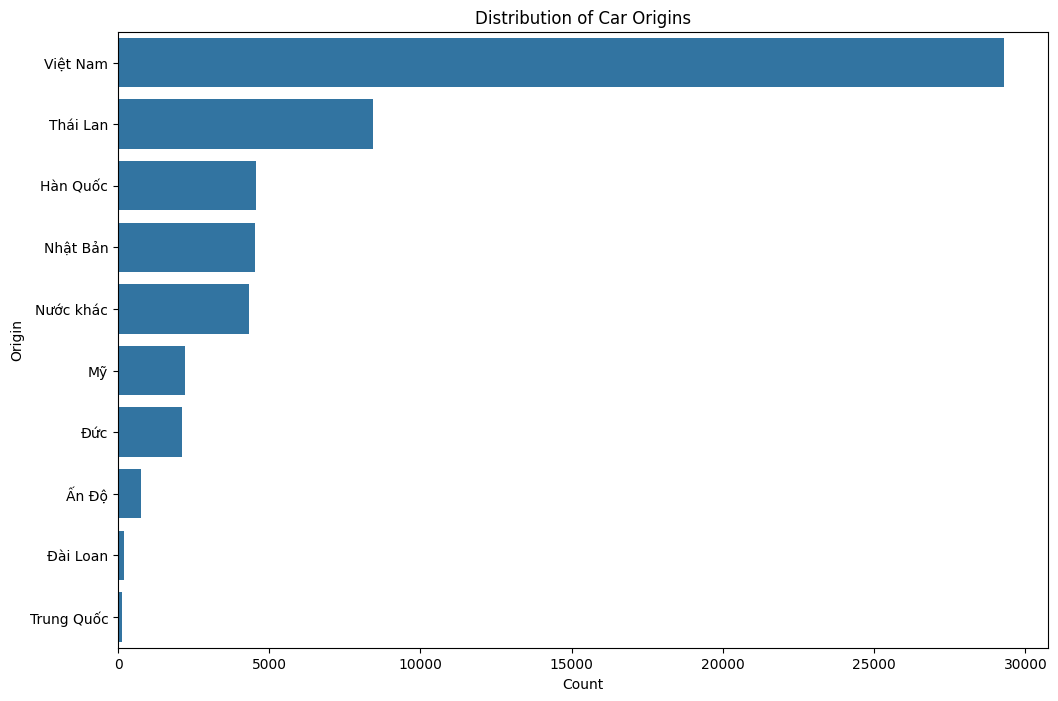

In [33]:
# Print the plot of origin
plt.figure(figsize=(12, 8))
sns.countplot(data=data, y='origin', order=data['origin'].value_counts().index)
plt.title('Distribution of Car Origins')
plt.xlabel('Count')
plt.ylabel('Origin')
plt.show()

In [36]:
# Print unique value for type of car
data['type'].unique()

['SUV / Cross over', 'Sedan', 'Minivan (MPV)', 'Van', 'Hatchback', 'Pick-up (bán tải)', NaN, 'Coupe (2 cửa)', 'Kiểu dáng khác', 'Mui trần']
Categories (9, object): ['Coupe (2 cửa)', 'Hatchback', 'Kiểu dáng khác', 'Minivan (MPV)', ..., 'Pick-up (bán tải)', 'SUV / Cross over', 'Sedan', 'Van']

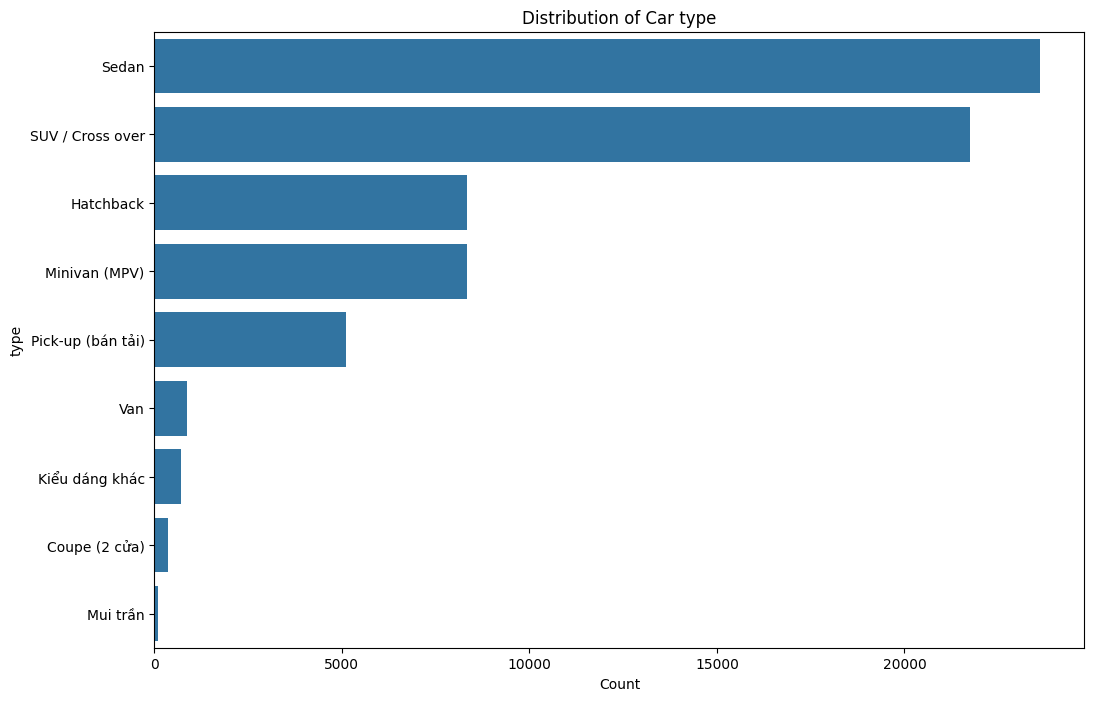

In [41]:
# Print the plot of origin
plt.figure(figsize=(12, 8))
sns.countplot(data=data, y='type', order=data['type'].value_counts().index)
plt.title('Distribution of Car type')
plt.xlabel('Count')
plt.ylabel('type')
plt.show()

In [39]:
# Print unique color of cars
data['color'].unique()

['green', 'white', NaN, 'black', 'grey', ..., 'blue', 'red', 'orange', 'pink', 'brown']
Length: 13
Categories (12, object): ['black', 'blue', 'brown', 'gold', ..., 'pink', 'red', 'silver', 'white']

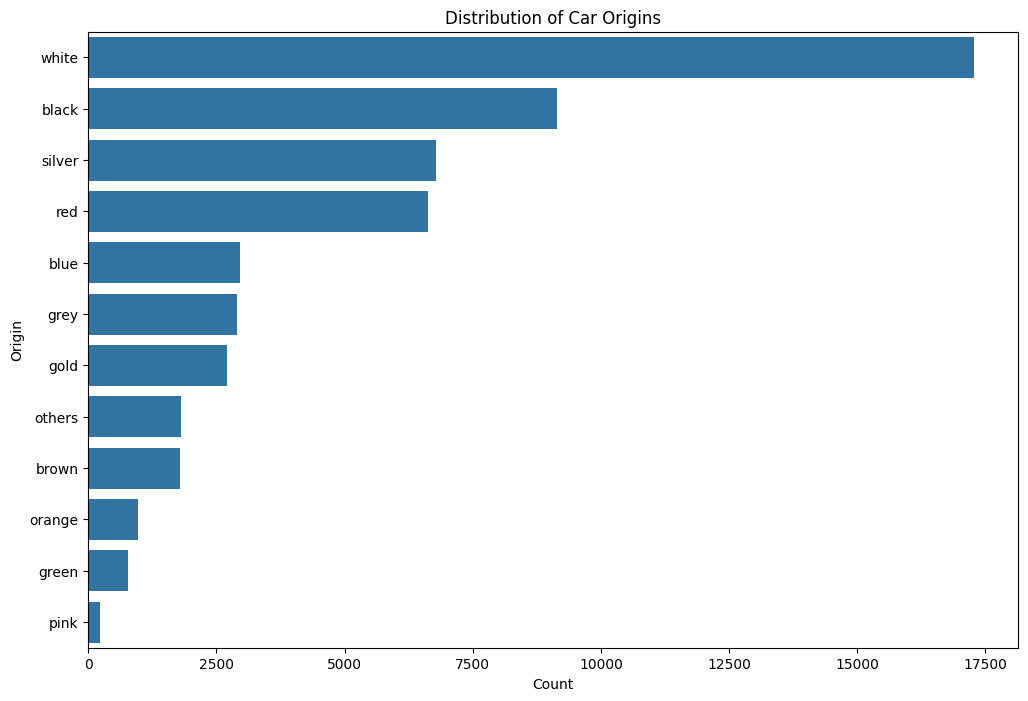

In [40]:
# Print the plot of origin
plt.figure(figsize=(12, 8))
sns.countplot(data=data, y='color', order=data['color'].value_counts().index)
plt.title('Distribution of Car color')
plt.ylabel('color')
plt.show()

## Handling outliers

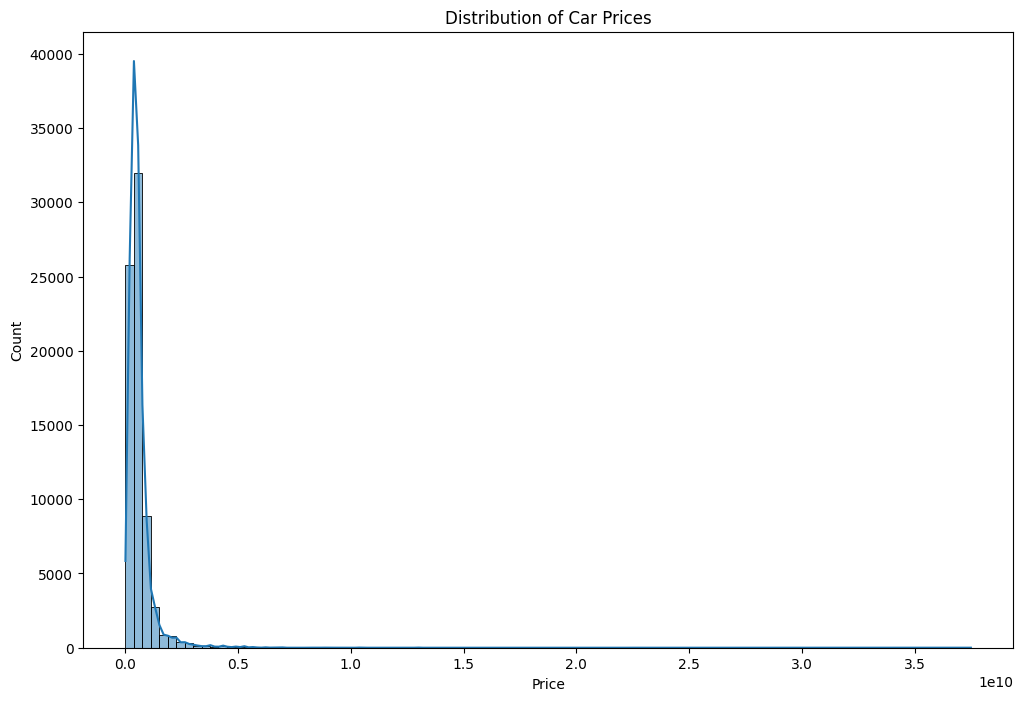

In [50]:
# Visualize the distribution of the target variable
plt.figure(figsize=(12, 8))
sns.histplot(data=data, x='price', bins=100, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

We can see that while most of the car is low price, some cars remain to be higher price, which raise awareness on how these model/brand/type have a very high price, therefore what we are going to do is check for those instances, however, we need to identify them first. 

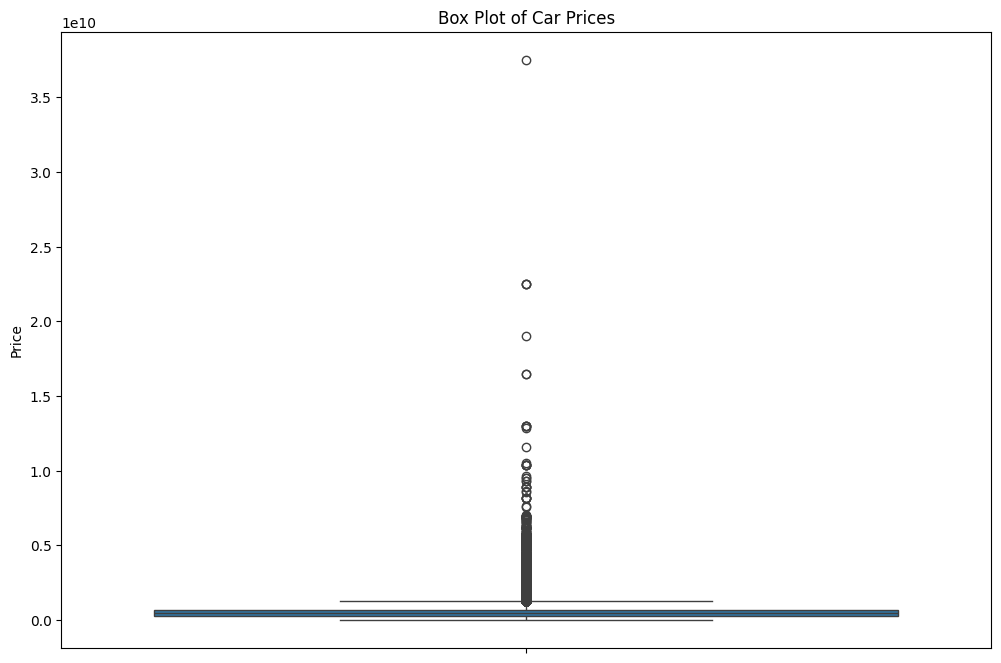

In [43]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, y='price')
plt.title('Box Plot of Car Prices')
plt.ylabel('Price')
plt.show()

In [45]:
# There is lots of outliers in the price column, we can investigate them further, using the IQR method. 
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data[(data['price'] < lower_bound) | (data['price'] > upper_bound)]
outliers

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,id_list_id_list_time
56,2023,Hyundai,Dòng khác,Hàn Quốc,SUV / Cross over,7.0,AT,oil,black,0,1.455556e+09,new,150061755_109974753_1694787390000
604,2023,Ford,Everest,Thái Lan,SUV / Cross over,7.0,AT,oil,black,0,1.468000e+09,new,150778078_110591374_1696661396000
701,2023,Ford,Dòng khác,Thái Lan,Pick-up (bán tải),5.0,AT,oil,others,0,1.299000e+09,new,150777822_110591160_1696661027000
1138,2019,Mercedes Benz,C Class,Đức,Sedan,5.0,AT,petrol,red,25000,1.268000e+09,used,148469801_108616316_1695052103972
1171,2022,Kia,Carnival,Việt Nam,Minivan (MPV),7.0,AT,oil,blue,13000,1.368000e+09,used,149502697_109493513_1695545417680
...,...,...,...,...,...,...,...,...,...,...,...,...,...
314630,2014,Mercedes Benz,S Class,NaN,Sedan,5.0,AT,petrol,NaN,680000,1.380000e+09,used,148285243_108459211_1696172292000
314870,2015,Mercedes Benz,S Class,Việt Nam,Sedan,5.0,AT,petrol,NaN,72000,1.295000e+09,used,150934482_110726113_1697076491000
314901,2015,Mercedes Benz,S Class,NaN,Sedan,5.0,AT,petrol,NaN,72000,1.285000e+09,used,151040579_110817684_1697345762000
315023,2015,Mercedes Benz,S Class,Việt Nam,Sedan,5.0,AT,petrol,NaN,72000,1.295000e+09,used,150934482_110726113_1697710086324


In [46]:
# percentage of condition in the outlier
outliers['condition'].value_counts(normalize=True) * 100

condition
used    78.757472
new     21.242528
Name: proportion, dtype: float64

In [47]:
data['condition'].value_counts(normalize=True) * 100

condition
used    87.211115
new     12.788885
Name: proportion, dtype: float64

We can see that the ratio for used/new from the outlier versus original data is lower, therefore it is quite right, since new car often have higher price than old car. What if it is the case where the saler overestimate the true value of the car? We need to investigate that at well. We can try and do this by compare the values to the one that is not outlier to see whether they are the same or not. 

This data is missing a lot. I am thinking about interpolate them, but it is only make sense if the distribution support this decision. Therefore i will try to display the distribution first.

# Feature Engineering

# Modeling and Evaluation

I will try with catboost, lgbm, xgboost and other regression models as well.

## Train and split test

In [69]:
# Define the features and target variable
X = data.drop(columns=['price', 'id_list_id_list_time'])
y = data['price']

# Split the data into training and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (50733, 11), (50733,)
Validation set: (10872, 11), (10872,)
Test set: (10872, 11), (10872,)


## Try with the baseline first
What we are going to do to establish a baseline is to build a simple model

In [78]:
from dataclasses import MISSING
import xgboost as xgb

# Define the models
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, MISSING=np.nan)

In [79]:
X_train

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,condition
166852,2017,Mercedes Benz,E Class,NaN,Sedan,5.0,AT,petrol,black,55000,used
263592,2011,Ford,Fiesta,Mỹ,Hatchback,5.0,AT,petrol,silver,11250,used
207353,2023,Ford,Ranger,Mỹ,Pick-up (bán tải),5.0,AT,oil,NaN,0,new
304385,2015,Ford,EcoSport,NaN,SUV / Cross over,5.0,AT,petrol,NaN,9000,used
206165,2012,Ford,Escape,Việt Nam,SUV / Cross over,5.0,AT,petrol,gold,82186,used
...,...,...,...,...,...,...,...,...,...,...,...
203512,1997,Nissan,Sunny,Nhật Bản,Sedan,5.0,AT,petrol,white,500000,used
17532,2017,Chevrolet,Aveo,Việt Nam,Sedan,5.0,MT,petrol,white,125648,used
253927,2017,Toyota,Fortuner,Nước khác,SUV / Cross over,7.0,MT,oil,brown,100000,used
1836,2022,Ford,Everest,Thái Lan,SUV / Cross over,7.0,AT,oil,white,39000,used


In [80]:
y_train

166852    9.490000e+08
263592    2.110000e+08
207353    6.720000e+08
304385    3.390000e+08
206165    2.900000e+08
              ...     
203512    4.500000e+07
17532     1.870000e+08
253927    6.890000e+08
1836      1.199000e+09
58404     5.100000e+08
Name: price, Length: 50733, dtype: float64

In [84]:
dtrain = xgb.DMatrix(X, label=y, enable_categorical=True, missing=np.NAN)
dval= xgb.DMatrix(X_val, label=y_val, enable_categorical=True, missing=np.NAN)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True, missing=np.NAN)

Since XGBoost need to specify to allow NaN, we have to create NaN for it as well.

In [98]:
xgb_params = {
    'objective': 'reg:squarederror',  # or any other objective
    'max_depth': 10,
    'eta': 0.3,
    'enable_categorical': True
}

/home/ngnqaq/anaconda3/envs/xai-venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:48:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Error: 5165396898742499.0
R^2 Score: 0.9860138575570261
Mean Absolute Error: 23232899.40871045


/home/ngnqaq/anaconda3/envs/xai-venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:48:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


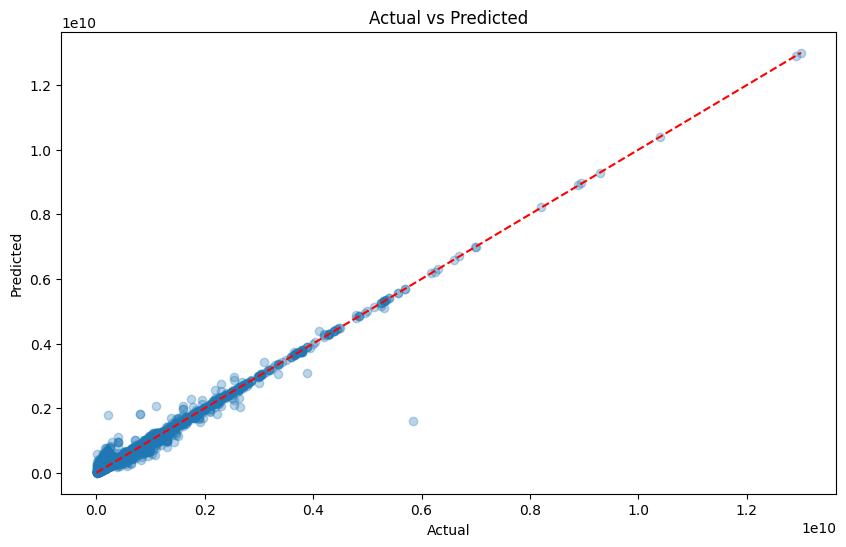

In [99]:
xgb_model=xgb.train(xgb_params, dtrain, num_boost_round=100, evals=[(dval, 'eval')], early_stopping_rounds=10, verbose_eval=0)
# Predict on the test set
y_pred = xgb_model.predict(dtest)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")

# Cross-Validation
cv_results = xgb.cv(xgb_params, dtrain, num_boost_round=100, nfold=5, metrics="rmse", as_pandas=True, seed=42)
cv_results
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [94]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,4.684621e+08,9.490593e+06,4.750988e+08,3.507863e+07
1,3.554684e+08,9.128771e+06,3.753351e+08,4.319219e+07
2,2.785100e+08,9.242551e+06,3.112938e+08,4.987196e+07
3,2.254378e+08,8.931056e+06,2.720112e+08,5.396146e+07
4,1.896414e+08,8.737491e+06,2.496330e+08,5.711178e+07
...,...,...,...,...
95,6.405002e+07,3.028293e+06,2.234504e+08,6.143709e+07
96,6.398252e+07,3.009206e+06,2.234440e+08,6.144142e+07
97,6.391624e+07,3.027785e+06,2.234871e+08,6.140993e+07
98,6.381254e+07,3.047724e+06,2.235011e+08,6.142882e+07


In [111]:
# Anyway, save the model first, then try to build api for this model
model_path

NameError: name 'model_path' is not defined

The result is quite ok, the R^2 is quite high tho. Let move on to catboost

In [ ]:
from catboost import CatBoostRegressor, Pool
categorical_features = data.select_dtypes(include='category').columns.tolist()
# convert data to str
df = data.copy() 
# Convert NaN values in categorical features to strings
df[categorical_features] = df[categorical_features].astype(str)
# Prepare data for CatBoost
X = df.drop(columns=['price','id_list_id_list_time'], axis=1)  # Replace 'target_column' with your target column name
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Pool for CatBoost
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)


In [109]:
# Define the model params
cat_params = {
    'loss_function': 'MAE',
    'iterations': 1000,
    'learning_rate': 0.1,
    'cat_features': categorical_features,
    'verbose': 100
}

0:	learn: 283829798.1870666	total: 112ms	remaining: 1m 51s
100:	learn: 114536840.2368544	total: 4.98s	remaining: 44.3s
200:	learn: 98215518.3072358	total: 9.8s	remaining: 39s
300:	learn: 90806549.1454088	total: 14.8s	remaining: 34.3s
400:	learn: 86056956.0824764	total: 19.2s	remaining: 28.6s
500:	learn: 83476427.4610225	total: 23.1s	remaining: 23s
600:	learn: 81520048.5997839	total: 27.4s	remaining: 18.2s
700:	learn: 79799321.8419072	total: 31.5s	remaining: 13.4s
800:	learn: 77777861.4153615	total: 36.2s	remaining: 8.99s
900:	learn: 76287902.7974121	total: 40s	remaining: 4.4s
999:	learn: 75248247.0915112	total: 52s	remaining: 0us
Mean Squared Error: 9.081702729986202e+16
R^2 Score: 0.760215859285955


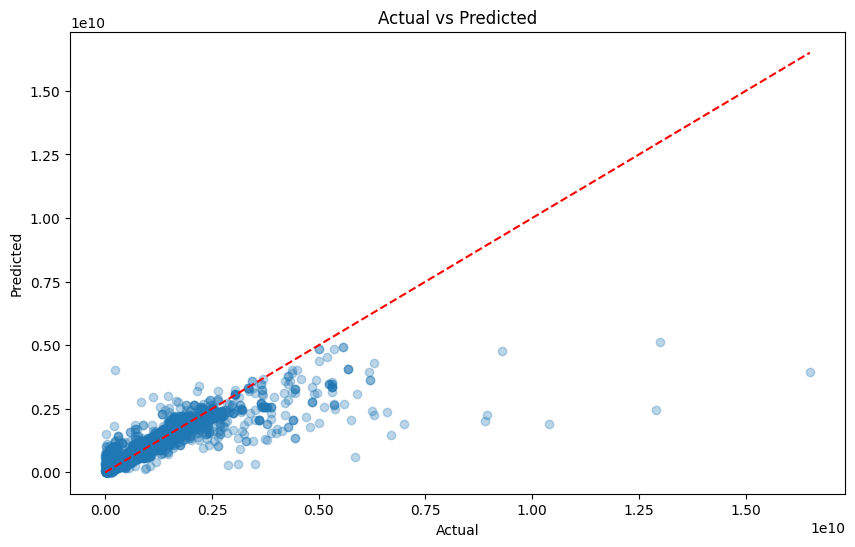

In [110]:
# Train the model
model = CatBoostRegressor(**cat_params)
model.fit(train_pool)

# Predict on the test set
y_pred = model.predict(test_pool)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

Hmmmmm, even worse than xgboost, let move on and try with lgbm